In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = "1"

In [2]:
import torch
import torch.nn as nn
import datasets
import transformers
import numpy as np
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torchsummary import summary
from transformers import AutoImageProcessor, ResNetForImageClassification
from transformers import BertTokenizer, BertModel

In [3]:
data = datasets.load_dataset("alkzar90/CC6204-Hackaton-Cub-Dataset")
device = "cuda" if torch.cuda.is_available() else "cpu"
train_data, test_data = data["train"], data["test"]
train_data

Dataset({
    features: ['image', 'description', 'label', 'file_name'],
    num_rows: 5994
})

2654
the bird has a massive black and white crown, a rounded, medium sized bill, and a white breast
the bird looks like is has a black and white mohawk on its head with a black, brown and white body
this bird has a black and white crown plume, short black beak, white breast, and light brown flank.
this is a strange brown bird with black and white feathers coming out of its crown.
this seabird has a black and white crown,white sides,black back and tail and a white breast
this bird is white with black and has a long, pointy beak.
this bird is white and black in color, with a long flat beak.
this bird has a large head, a black bill, and a white breast.
this water bird is black, white, and beige, with lots of tall plumage on its crown.
this bird has a white breast with a black stripe, black wingbars, and a black beak.



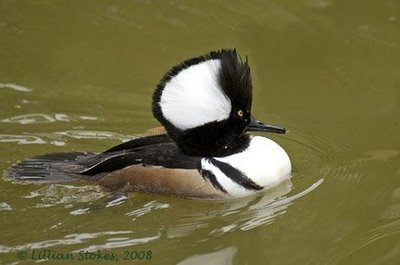

88


In [4]:
def match_random_sample():
    n = np.random.randint(0, len(train_data))
    print(n)
    print(train_data[n]["description"])
    train_data[n]["image"].show()
    print(train_data[n]["label"])


match_random_sample()

In [5]:

processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
image_model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")
image_model.classifier[-1] = nn.Linear(2048, 768)
image_model = image_model.to(device)

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
text_model = BertModel.from_pretrained("bert-base-uncased")
text_model = text_model.to(device)


embedding_sim = nn.CosineSimilarity()


def batch_image_embed(batch):
    input_data = processor(images=batch, return_tensors="pt")
    input_data = input_data.to(device)
    return image_model(**input_data).logits


def batch_text_embed(batch):
    encoded_input = tokenizer(batch, return_tensors="pt", padding="max_length")
    encoded_input = encoded_input.to(device)
    output = text_model(**encoded_input).last_hidden_state
    return output.mean(dim=1)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [6]:
img = train_data[0]['image']
text = train_data[0]['description']

img_e = batch_image_embed(img)
text_e = batch_text_embed(text)

img_e.shape, text_e.shape

(torch.Size([1, 768]), torch.Size([1, 768]))

In [7]:
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(768 * 2, 200) # 2 * d -> num_classes
    def forward(self, images, texts):
        img_e = batch_image_embed(images)
        text_e = batch_text_embed(texts)
        MLP_input = torch.cat((img_e, text_e), dim=1)
        x = self.linear1(MLP_input)
        return x

In [8]:
def convert_img(elem):
    return elem['image'].mode == "RGB"


train_data = train_data.shuffle()
train_data = train_data.filter(convert_img, num_proc=16)

ids = np.array(range(len(test_data)))
rand_ids = np.random.choice(ids, size=1000, replace=False)
val_data = test_data.select(rand_ids)
val_data = val_data.filter(convert_img, num_proc=16)
val_data.set_format('torch')
val_data

Filter (num_proc=16):   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'description', 'label', 'file_name'],
    num_rows: 999
})

### Training part

In [9]:
lin_model = LinearModel().to(device)
loss_fun = nn.CrossEntropyLoss(reduction='sum')
lr = 1e-3
optimizer = torch.optim.SGD(lin_model.parameters(), lr)
epoch_num = 5
batch_size = 32

In [10]:
def validate():
    loss_hist = []
    true_preds = 0
    sum_loss = 0
    processed_samples = 0
    progress = tqdm(range(0, len(val_data) - batch_size, batch_size))
    lin_model.eval()
    with torch.no_grad():
        for j in progress:
            batch = val_data[j:j+batch_size]
            images, texts, labels, _ = batch.values()
            labels = labels.to(device)

            output = lin_model(images, texts)
            loss = loss_fun(output, labels)

            preds = torch.argmax(output, dim=1)
            correct = torch.sum(preds == labels).item()
            true_preds += correct
            sum_loss += loss.item()
            loss_hist.append(loss.item())
            progress.set_description(f"Loss: {loss.item():.3f}, Correct: {correct}")
            processed_samples += batch_size
    print(f"Mean val Loss: {sum_loss / (processed_samples / batch_size)}")
    print(f"Val accuracy: {true_preds / processed_samples}")

In [11]:
def train():
    loss_hist = []
    for i in range(epoch_num):
        print('EPOCH: ', i+1)
        true_preds = 0
        sum_loss = 0
        processed_samples = 0
        progress = tqdm(range(0, len(train_data) - batch_size, batch_size))
        lin_model.train()
        for j in progress:
            optimizer.zero_grad()

            batch = train_data[j:j+batch_size]
            images, texts, labels, _ = batch.values()
            labels = torch.tensor(labels, device=device)

            output = lin_model(images, texts)
            loss = loss_fun(output, labels)
            loss.backward()
            optimizer.step()

            preds = torch.argmax(output, dim=1)
            correct = torch.sum(preds == labels).item()
            true_preds += correct
            sum_loss += loss.item()
            loss_hist.append(loss.item())
            progress.set_description(f"Loss: {loss.item():.3f}, Correct: {correct}")
            processed_samples += batch_size
        print(f"Mean epoch Loss: {sum_loss / (processed_samples / batch_size)}")
        print(f"Epoch accuracy: {true_preds / processed_samples}")
        validate()
        print('='*75)
    return loss_hist

loss_hist = train()

EPOCH:  1


  0%|          | 0/187 [00:00<?, ?it/s]

Mean epoch Loss: 170.02345667548357
Epoch accuracy: 0.003676470588235294


  0%|          | 0/31 [00:00<?, ?it/s]

Mean val Loss: 168.69290850239415
Val accuracy: 0.010080645161290322
EPOCH:  2


  0%|          | 0/187 [00:00<?, ?it/s]

Mean epoch Loss: 168.9764012627423
Epoch accuracy: 0.0106951871657754


  0%|          | 0/31 [00:00<?, ?it/s]

Mean val Loss: 167.7848382765247
Val accuracy: 0.018145161290322582
EPOCH:  3


  0%|          | 0/187 [00:00<?, ?it/s]

Mean epoch Loss: 167.92559806293346
Epoch accuracy: 0.025066844919786096


  0%|          | 0/31 [00:00<?, ?it/s]

Mean val Loss: 166.83672701927924
Val accuracy: 0.03931451612903226
EPOCH:  4


  0%|          | 0/187 [00:00<?, ?it/s]

Mean epoch Loss: 166.871047484046
Epoch accuracy: 0.043114973262032084


  0%|          | 0/31 [00:00<?, ?it/s]

Mean val Loss: 165.88932504961568
Val accuracy: 0.06854838709677419
EPOCH:  5


  0%|          | 0/187 [00:00<?, ?it/s]

Mean epoch Loss: 165.82234045018487
Epoch accuracy: 0.06834893048128342


  0%|          | 0/31 [00:00<?, ?it/s]

Mean val Loss: 164.94799066358996
Val accuracy: 0.08870967741935484


### Loss history plot

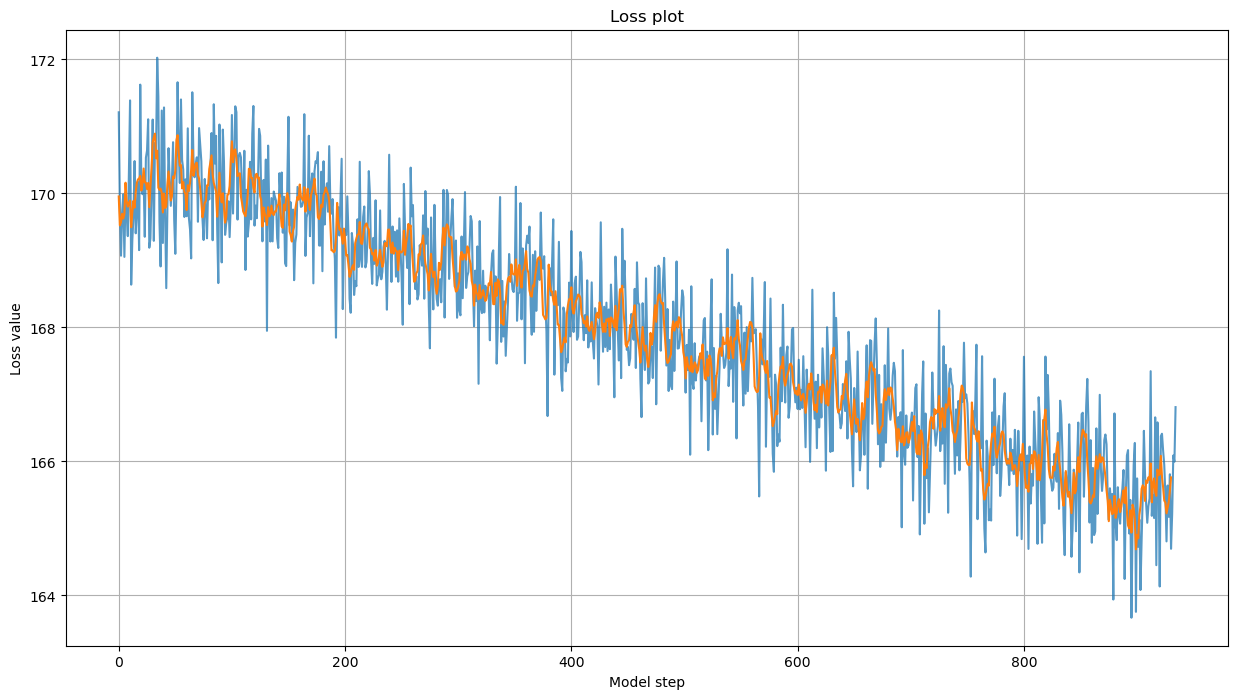

In [12]:
import matplotlib.pyplot as plt
# Smoothing function using a moving average
def moving_average(data, window_size):
    weights = np.repeat(1.0, window_size) / window_size
    return np.convolve(data, weights, 'valid')

# Define the window size for the moving average
window_size = 5

# Smooth the loss data using the moving average
smoothed_loss = moving_average(loss_hist, window_size)


plt.figure(figsize=(15, 8))
plt.plot(loss_hist, alpha=0.75)
plt.plot(smoothed_loss)
plt.grid()
plt.title('Loss plot')
plt.xlabel('Model step')
plt.ylabel('Loss value')
plt.savefig('SGD1.png')